# Classification Experiments

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import parselmouth
from parselmouth.praat import call
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.models as models
from tensorflow.keras.utils import to_categorical
from classificationreport import ClassificationReport ## this is a python script provided in the directory

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import subprocess
import os
import csv

## Using INTERSPEECH 2009 Emotion Challenge feature set

In [203]:
opensmile_list = []

This function accepts the file name and file path of the speech file, extracts the Interspeech 2009 Emotion Challenge feature set from each wav file and saves it as a csv in the opensmile features folder in the format - "speaker_session_emotion_start-time_transcript.csv"
After the speech features are saved, the csv file is opened and appended to the list declared above, "opensmile_list" which is then converted to a pandas dataframe and saved as csv so I won't have to repeat the feature extraction process.

In [204]:
def extract_opensmile_features(file_name, speech_files_folder):
	file_path = os.path.join(speech_files_folder, file_name)
	subprocess.run(["../opensmile-3.0.1-win-x64/bin/SMILExtract", "-C", 
	                "../opensmile-3.0.1-win-x64/config/is09-13/IS09_emotion.conf",
									"-I", file_path, "-headercsv", "1","-csvoutput", 
									"./opensmile_features/" + file_name[:-4] + ".csv", 
									"--instname", file_name[:-4]])
	csv_file = "./opensmile_features/" + file_name[:-4] + ".csv"
	with open(csv_file) as f:
		file_data=csv.reader(f, delimiter=';', quotechar="'")
		headers=next(file_data)
		return[dict(zip(headers,i)) for i in file_data][0]

In [206]:
speech_files_folder = "./hw3_speech_files/" 
for file_name in os.listdir(speech_files_folder):
    if file_name.endswith(".wav"):
        opensmile_list.append(extract_opensmile_features(file_name, speech_files_folder))

In [208]:
opensmile_df = pd.DataFrame(opensmile_list)
opensmile_df.shape

(2324, 386)

In [220]:
opensmile_df.head()

,name,frameTime,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,...,F0_sma_de_range,F0_sma_de_maxPos,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis
0,cc_001_anxiety_910.77_May-twenty-third,0.0,0.019556,0.000098,0.019459,28,0,0.005757,-0.000034,0.007680,...,132.02450,68,72,-5.437617e-08,-0.009950,0.562178,239.2275,15.470450,-1.312268e-02,11.23654
1,cc_001_anxiety_916.11_Eight-hundred-eight,0.0,0.020914,0.000058,0.020856,63,0,0.006449,-0.000096,0.012574,...,243.30440,34,38,-1.862645e-08,-0.012806,0.813158,710.0782,26.651490,1.785000e-02,12.79744
2,cc_001_anxiety_918.66_Eight-hundred-eight,0.0,0.027904,0.000117,0.027787,88,128,0.007473,-0.000076,0.012335,...,0.00000,0,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000
3,cc_001_anxiety_928.48_Four-thousand-eight,0.0,0.052467,0.000205,0.052262,40,109,0.015300,-0.000016,0.016177,...,187.57450,21,24,0.000000e+00,-0.008456,0.460871,328.6690,18.131220,2.774320e-17,20.26844
4,cc_001_anxiety_934.73_Nine-thousand-six,0.0,0.074559,0.000146,0.074414,107,139,0.016310,0.000079,0.010823,...,81.43034,9,17,1.362392e-08,-0.005247,0.364690,67.0573,8.191598,8.360357e-01,19.55287


The 'name' column in the dataframe is split into 'speaker', 'session', 'emotion','start_time', and 'transcript' so that I can easily extract the emotion and speaker from each row.

In [221]:
opensmile_df[['speaker', 'session', 'emotion','start_time', 'transcript']] = opensmile_df['name'].str.split('_',expand=True)

In [222]:
opensmile_df.head()

,name,frameTime,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,...,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis,speaker,session,emotion,start_time,transcript
0,cc_001_anxiety_910.77_May-twenty-third,0.0,0.019556,0.000098,0.019459,28,0,0.005757,-0.000034,0.007680,...,0.562178,239.2275,15.470450,-1.312268e-02,11.23654,cc,001,anxiety,910.77,May-twenty-third
1,cc_001_anxiety_916.11_Eight-hundred-eight,0.0,0.020914,0.000058,0.020856,63,0,0.006449,-0.000096,0.012574,...,0.813158,710.0782,26.651490,1.785000e-02,12.79744,cc,001,anxiety,916.11,Eight-hundred-eight
2,cc_001_anxiety_918.66_Eight-hundred-eight,0.0,0.027904,0.000117,0.027787,88,128,0.007473,-0.000076,0.012335,...,0.000000,0.0000,0.000000,0.000000e+00,0.00000,cc,001,anxiety,918.66,Eight-hundred-eight
3,cc_001_anxiety_928.48_Four-thousand-eight,0.0,0.052467,0.000205,0.052262,40,109,0.015300,-0.000016,0.016177,...,0.460871,328.6690,18.131220,2.774320e-17,20.26844,cc,001,anxiety,928.48,Four-thousand-eight
4,cc_001_anxiety_934.73_Nine-thousand-six,0.0,0.074559,0.000146,0.074414,107,139,0.016310,0.000079,0.010823,...,0.364690,67.0573,8.191598,8.360357e-01,19.55287,cc,001,anxiety,934.73,Nine-thousand-six


In [223]:
opensmile_df.to_csv('opensmile_features.csv')

The saved csv file is read back into a pandas dataframe.

In [48]:
df = pd.read_csv('opensmile_features.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.dtypes

name                        object
frameTime                  float64
pcm_RMSenergy_sma_max      float64
pcm_RMSenergy_sma_min      float64
pcm_RMSenergy_sma_range    float64
                            ...   
speaker                     object
session                      int64
emotion                     object
start_time                 float64
transcript                  object
Length: 391, dtype: object

In [49]:
df.head()

,name,frameTime,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,...,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis,speaker,session,emotion,start_time,transcript
0,cc_001_anxiety_910.77_May-twenty-third,0.0,0.019556,0.000098,0.019459,28,0,0.005757,-0.000034,0.007680,...,0.562178,239.2275,15.470450,-1.312268e-02,11.23654,cc,1,anxiety,910.77,May-twenty-third
1,cc_001_anxiety_916.11_Eight-hundred-eight,0.0,0.020914,0.000058,0.020856,63,0,0.006449,-0.000096,0.012574,...,0.813158,710.0782,26.651490,1.785000e-02,12.79744,cc,1,anxiety,916.11,Eight-hundred-eight
2,cc_001_anxiety_918.66_Eight-hundred-eight,0.0,0.027904,0.000117,0.027787,88,128,0.007473,-0.000076,0.012335,...,0.000000,0.0000,0.000000,0.000000e+00,0.00000,cc,1,anxiety,918.66,Eight-hundred-eight
3,cc_001_anxiety_928.48_Four-thousand-eight,0.0,0.052467,0.000205,0.052262,40,109,0.015300,-0.000016,0.016177,...,0.460871,328.6690,18.131220,2.774320e-17,20.26844,cc,1,anxiety,928.48,Four-thousand-eight
4,cc_001_anxiety_934.73_Nine-thousand-six,0.0,0.074559,0.000146,0.074414,107,139,0.016310,0.000079,0.010823,...,0.364690,67.0573,8.191598,8.360357e-01,19.55287,cc,1,anxiety,934.73,Nine-thousand-six


In order to normalize the features, I created a DataFrameGroupBy object and chose a subset of the features to normalize that will be used in the final model. The "F0_sma_min", and "F0_sma_minPos" columns have been dropped as maximum values in these were 0s resulting in a 0 standard deviation and it would not have be useful for classification.

In [50]:
grouped = df.groupby("speaker")
features = df.drop(["name","frameTime", "speaker", "session", "emotion", "start_time", "transcript", "F0_sma_min", "F0_sma_minPos"], axis=1).columns

In [51]:
features.shape

(382,)

Normalize all the features

In [6]:
for feature in features:
    mean = grouped[feature].transform(np.mean)
    std = grouped[feature].transform(np.std)
    df[feature] = (df[feature] - mean) / std

In [7]:
le_emotion = LabelEncoder()
df['emotion'] = le_emotion.fit_transform(df['emotion'])
class_names = le_emotion.classes_

Create a series for the speakers so that we can implement Leave-one-speaker-out cross-validation.

In [8]:
speakers = pd.Series(df.speaker)
n_splits = speakers.nunique()

In [9]:
X = df.iloc[:,2:-5]
y = df.loc[:,'emotion']

In [10]:
for i in X.columns:
    if X[i].isnull().sum() > 0:
        print(i, X[i].isnull().sum())


In [11]:
logo = LeaveOneGroupOut()

The extracted and normalized features are trained on a Random Forest Model and the weighted aggregated accuracy and F1 score is calculated. The maximum accuracy and F1 score obtained from this set of features was ~20%

Speaker group in test set is: ['cc']
Random Forest Accuracy:  0.16226415094339622
              precision    recall  f1-score   support

     anxiety       0.02      0.10      0.03        10
     boredom       0.09      0.13      0.11        15
  cold-anger       0.00      0.00      0.00        15
    contempt       0.26      0.32      0.29        22
     despair       0.00      0.00      0.00         9
     disgust       0.42      0.16      0.23        31
     elation       0.09      0.12      0.11        16
       happy       0.21      0.17      0.19        23
   hot-anger       0.35      0.79      0.49        14
    interest       0.26      0.29      0.28        17
     neutral       0.00      0.00      0.00        18
       panic       0.43      0.17      0.24        18
       pride       0.00      0.00      0.00        23
     sadness       0.09      0.08      0.08        13
       shame       0.15      0.10      0.12        21

    accuracy                           0.16       26

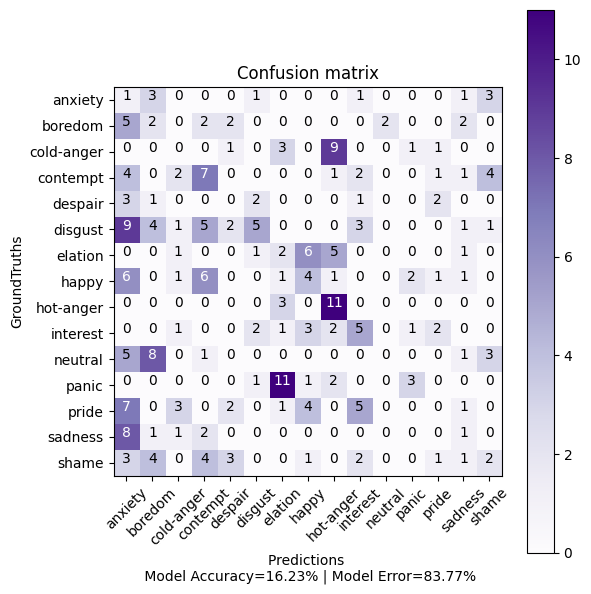

Speaker group in test set is: ['cl']
Random Forest Accuracy:  0.22010869565217392
              precision    recall  f1-score   support

     anxiety       0.09      0.14      0.11        21
     boredom       0.30      0.69      0.42        29
  cold-anger       0.47      0.26      0.33        27
    contempt       0.15      0.24      0.18        25
     despair       0.21      0.14      0.17        29
     disgust       0.11      0.14      0.12        22
     elation       0.08      0.04      0.05        27
       happy       0.41      0.43      0.42        21
   hot-anger       0.44      0.65      0.52        26
    interest       0.04      0.04      0.04        26
     neutral       0.00      0.00      0.00        17
       panic       0.15      0.14      0.15        21
       pride       0.29      0.08      0.13        24
     sadness       0.09      0.04      0.05        27
       shame       0.14      0.15      0.15        26

    accuracy                           0.22       36

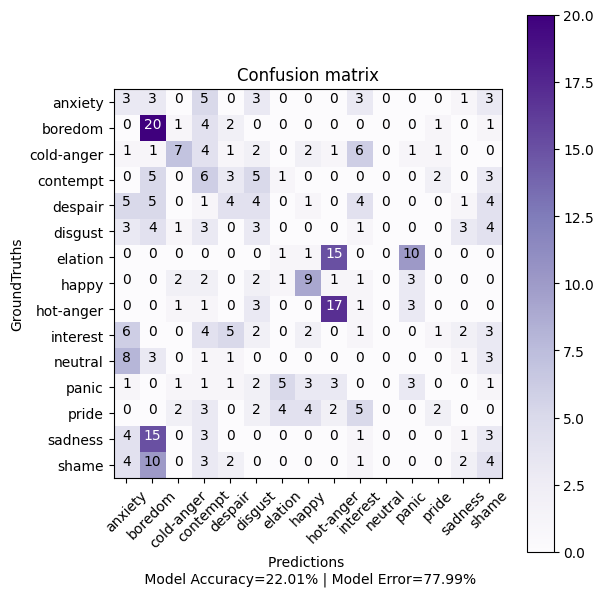

Speaker group in test set is: ['gg']
Random Forest Accuracy:  0.24523809523809523
              precision    recall  f1-score   support

     anxiety       0.44      0.40      0.42        30
     boredom       0.14      0.10      0.12        30
  cold-anger       0.10      0.11      0.11        27
    contempt       0.18      0.35      0.24        26
     despair       0.13      0.11      0.12        28
     disgust       0.25      0.06      0.10        51
     elation       0.38      0.64      0.48        28
       happy       0.29      0.67      0.41        30
   hot-anger       0.42      0.45      0.43        22
    interest       0.07      0.07      0.07        30
     neutral       0.00      0.00      0.00         9
       panic       0.57      0.30      0.39        27
       pride       0.14      0.12      0.13        25
     sadness       0.00      0.00      0.00        33
       shame       0.25      0.38      0.30        24

    accuracy                           0.25       42

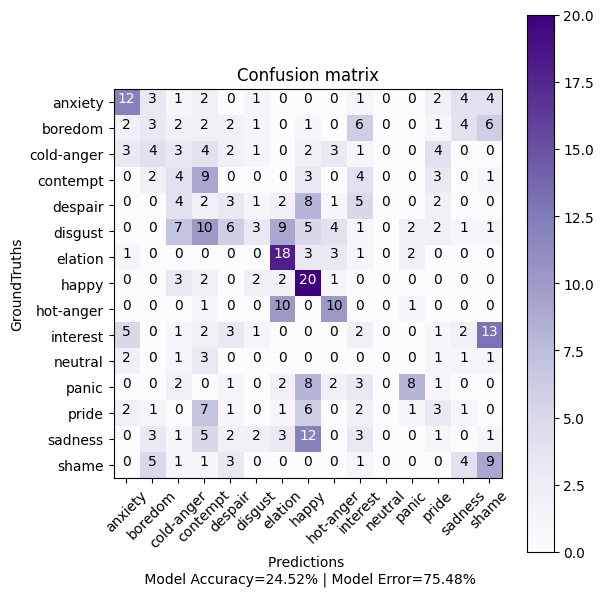

Speaker group in test set is: ['jg']
Random Forest Accuracy:  0.16483516483516483
              precision    recall  f1-score   support

     anxiety       0.18      0.32      0.23        19
     boredom       0.18      0.21      0.19        14
  cold-anger       0.30      0.14      0.19        22
    contempt       0.17      0.17      0.17        23
     despair       0.00      0.00      0.00        21
     disgust       0.29      0.39      0.33        23
     elation       0.20      0.15      0.17        20
       happy       0.10      0.10      0.10        20
   hot-anger       0.29      0.28      0.29        18
    interest       0.13      0.21      0.16        19
     neutral       0.00      0.00      0.00         8
       panic       0.06      0.07      0.07        14
       pride       0.09      0.11      0.10        18
     sadness       0.20      0.05      0.08        19
       shame       0.12      0.13      0.13        15

    accuracy                           0.16       27

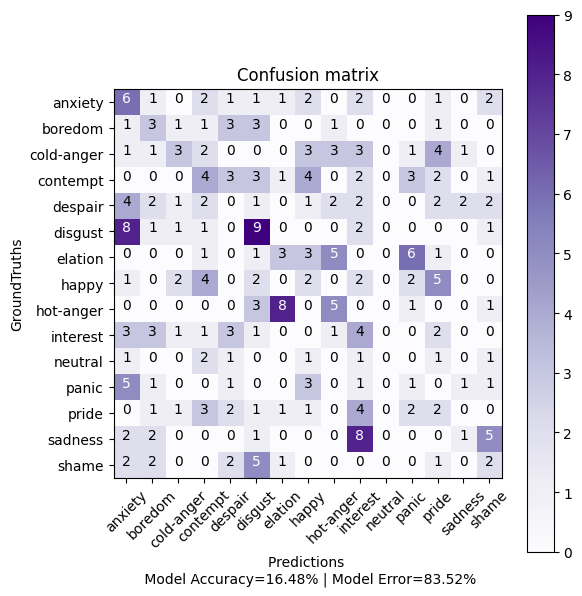

Speaker group in test set is: ['mf']
Random Forest Accuracy:  0.20735785953177258
              precision    recall  f1-score   support

     anxiety       0.27      0.36      0.31        22
     boredom       0.20      0.11      0.14        27
  cold-anger       0.20      0.20      0.20        20
    contempt       0.50      0.27      0.35        44
     despair       0.00      0.00      0.00        16
     disgust       0.02      1.00      0.05         1
     elation       0.11      0.12      0.11        26
       happy       0.06      0.09      0.07        23
   hot-anger       0.45      0.43      0.44        21
    interest       0.14      0.11      0.12        19
     neutral       0.38      0.30      0.33        10
       panic       0.55      0.50      0.52        12
       pride       0.14      0.06      0.08        18
     sadness       0.08      0.05      0.06        20
       shame       0.32      0.35      0.33        20

    accuracy                           0.21       29

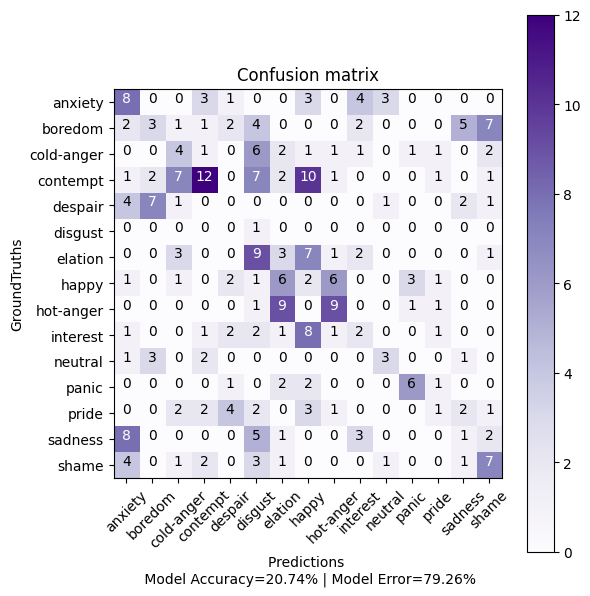

Speaker group in test set is: ['mk']
Random Forest Accuracy:  0.1712846347607053
              precision    recall  f1-score   support

     anxiety       0.11      0.21      0.14        29
     boredom       0.12      0.15      0.14        20
  cold-anger       0.15      0.09      0.11        23
    contempt       0.05      0.10      0.07        21
     despair       0.00      0.00      0.00        53
     disgust       0.03      0.05      0.03        21
     elation       0.21      0.39      0.27        23
       happy       0.38      0.33      0.35        42
   hot-anger       0.28      0.32      0.30        22
    interest       0.19      0.14      0.16        44
     neutral       0.00      0.00      0.00         8
       panic       0.38      0.38      0.38        21
       pride       0.05      0.04      0.05        23
     sadness       0.40      0.09      0.15        22
       shame       0.23      0.28      0.25        25

    accuracy                           0.17       397

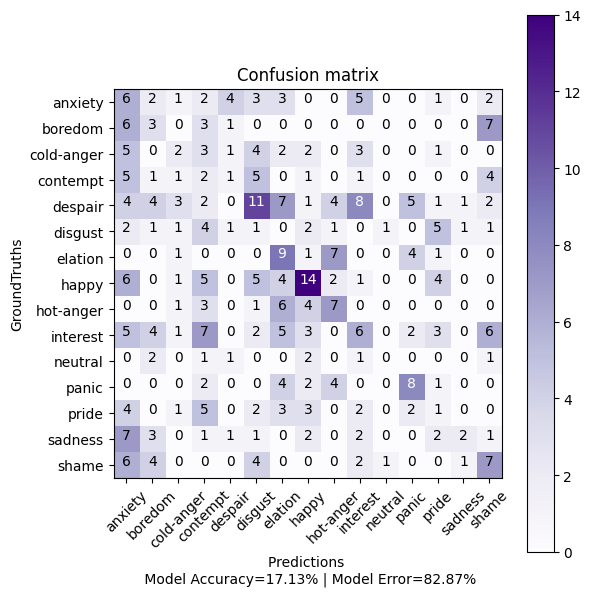

Speaker group in test set is: ['mm']
Random Forest Accuracy:  0.25496688741721857
              precision    recall  f1-score   support

     anxiety       0.36      0.21      0.26        39
     boredom       0.18      0.26      0.21        19
  cold-anger       0.00      0.00      0.00        20
    contempt       0.20      0.26      0.23        19
     despair       0.09      0.06      0.07        18
     disgust       0.24      0.26      0.25        23
     elation       0.40      0.32      0.35        19
       happy       0.29      0.67      0.40        18
   hot-anger       0.25      0.31      0.28        16
    interest       0.23      0.33      0.27        21
     neutral       0.00      0.00      0.00         9
       panic       0.50      0.18      0.26        28
       pride       0.40      0.32      0.35        19
     sadness       0.08      0.12      0.10        17
       shame       0.35      0.53      0.42        17

    accuracy                           0.25       30

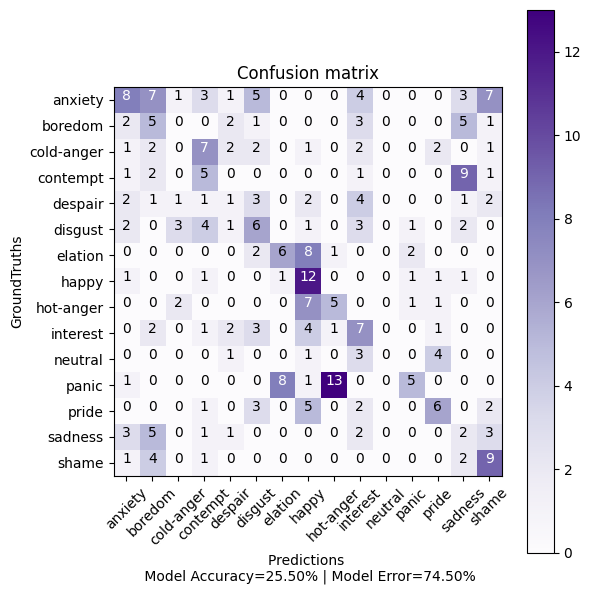

Aggregated average accuracy = 20.61%
Aggregated average F1-score = 18.75%


In [12]:
agg_acc = []
agg_f1 = []
for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, speakers)):
        print(f"Speaker group in test set is: {df.iloc[test_idx]['speaker'].unique()}")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        rfc = RandomForestClassifier(random_state=42)
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        agg_acc.append(acc * len(y_test))
        agg_f1.append(f1 * len(y_test))
        print("Random Forest Accuracy: ", acc)
        print(classification_report(y_test, y_pred, target_names=class_names))
        cm = confusion_matrix(y_test, y_pred)
        cr = ClassificationReport()
        cr.plot_confusion_matrix(cm=cm, normalize = False, target_names = class_names)
agg_avg_acc = sum(agg_acc) / len(df)
agg_avg_f1 = sum(agg_f1) / len(df)
print(f"Aggregated average accuracy = {round(agg_avg_acc*100,2)}%")
print(f"Aggregated average F1-score = {round(agg_avg_f1*100,2)}%")

## Using MFCC feature set

I also experimented with the MFCC configuration provided with the opensmile toolkit. The function accepts the file name and file path of the speech file, extracts the MFCC feature set from each wav file and saves it as a csv in the opensmile mfcc folder in the format - "speaker_session_emotion_start-time_transcript.csv".

In [15]:
def extract_opensmile_mfcc(file_name, speech_files_folder):
	file_path = os.path.join(speech_files_folder, file_name)
	subprocess.run(["../opensmile-3.0.1-win-x64/bin/SMILExtract", "-C", 
	                "../opensmile-3.0.1-win-x64/config/mfcc/MFCC12_0_D_A.conf",
									"-I", file_path, "-headercsv", "1","-csvoutput", 
									"./opensmile_mfcc/" + file_name[:-4] + ".csv", 
									"--instname", file_name[:-4]])

In [129]:
speech_files_folder = "./hw3_speech_files/" 
for file_name in os.listdir(speech_files_folder):
    if file_name.endswith(".wav"):
        extract_opensmile_mfcc(file_name, speech_files_folder)

Next, I iterated over a directory containing MFCC feature files in CSV format. For each file, the following steps are performed - 
- read the CSV data using pandas, and split the file name into its components (speaker, session, emotion, start_time, and transcript)
- extracts the MFCC features from the CSV data, and average the MFCC features over three equal parts
- stacks these three averaged parts into a 2D array and appends it to a list, which will contain all the MFCC feature arrays. <br>

Finally, the emotion labels and speaker labels are also concatenated.

In [13]:
i=0
mfcc_files_folder = "./opensmile_mfcc/" 
X = []
Y = []
G = []
for file_name in os.listdir(mfcc_files_folder):
    if file_name.endswith(".csv"):
        file_path = mfcc_files_folder + file_name
        df_mfcc = pd.read_csv(file_path, sep=';', quotechar="'")
        df_mfcc[['speaker', 'session', 'emotion','start_time', 'transcript']] = df_mfcc['name'].str.split('_',expand=True)
        features = df_mfcc[df_mfcc.columns[2:-5]].to_numpy()
        n = (int)(len(features)/3)
        n1 = features[:n]
        n2 = features[n:2*n]
        n3 = features[2*n:]
        emotion = df_mfcc.loc[0, 'emotion']
        speaker = df_mfcc.loc[0, 'speaker']
        x = np.stack((np.average(n1, axis=0), np.average(n2, axis=0), np.average(n3, axis=0))).T
        X.append(x)
        Y.append(emotion)
        G.append(speaker)
        i+=1
        if i%200 == 0:
            print(f"{i} files procesed")


200 files procesed
400 files procesed
600 files procesed
800 files procesed
1000 files procesed
1200 files procesed
1400 files procesed
1600 files procesed
1800 files procesed
2000 files procesed
2200 files procesed


The MFCC features are converted to a numpy array, the emotions and encoded and converted to a one-hot encoded form and the speakergroups are converted to a series to perform Leave-one-speaker-out cross-validation.

In [14]:
X = np.asarray(X)
X.shape

(2324, 39, 3)

In [15]:
le_emotion_mfcc = LabelEncoder()
Y = le_emotion_mfcc.fit_transform(Y)
Y = to_categorical(Y)
class_names = le_emotion_mfcc.classes_

In [16]:
speakers = pd.Series(G)
n_splits = speakers.nunique()

In [17]:
logo = LeaveOneGroupOut()

Create a convolutional neural network (CNN) model for classification of MFCC features.
The model architecture has been taken from my Github repo (https://github.com/Ritika2001/Kervolution-Based-SubSpectralNet/blob/main/Code/WithConvolution/Baseline.py)



In [42]:
inputLayer = Input((39, 3))

CONV = Conv1D(32, kernel_size=(7), padding='same')(inputLayer)
CONV = BatchNormalization(axis=1)(CONV)
CONV = Activation('relu')(CONV)
CONV = MaxPooling1D((5))(CONV)
CONV = Dropout(0.3)(CONV)

CONV = Conv1D(64, kernel_size=(7), padding='same')(CONV)
CONV = BatchNormalization(axis=1)(CONV)
CONV = Activation('relu')(CONV)
CONV = MaxPooling1D((4))(CONV)
CONV = Dropout(0.30)(CONV)

FLATTEN = Flatten()(CONV)
DENSE = Dense(100, activation='relu')(FLATTEN)
DROPOUT = Dropout(0.30)(DENSE)
    
outputLayer = Dense(15, activation='softmax')(DROPOUT)

classification_model = Model(inputLayer, outputLayer)

print(classification_model.summary())

es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.001, patience=3, mode = "max", restore_best_weights = True)

classification_model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy']) 

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 39, 3)]           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 39, 32)            704       
                                                                 
 batch_normalization_16 (Bat  (None, 39, 32)           156       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 39, 32)            0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 7, 32)            0         
 g1D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 7, 32)             0   

In [28]:
tf.config.run_functions_eagerly(True)

The model is compiled and trained on 6 speakers while in each case 1 speaker is used as a test set. The model accuracy on using the MFCC features along with a CNN model is ~80-85% which is much higher than the accuracy and F1 obtained using the interspeech 2009 feature set.

Speaker group in test set is: ['cc']
9/9 [==============================] - 0s 10ms/step
Convolutional Neural Network Accuracy:  0.8641509433962264
              precision    recall  f1-score   support

     anxiety       0.80      0.80      0.80        10
     boredom       0.73      0.73      0.73        15
  cold-anger       1.00      0.47      0.64        15
    contempt       0.85      1.00      0.92        22
     despair       0.90      1.00      0.95         9
     disgust       0.94      0.97      0.95        31
     elation       0.78      0.88      0.82        16
       happy       0.85      0.74      0.79        23
   hot-anger       0.81      0.93      0.87        14
    interest       0.94      0.94      0.94        17
     neutral       0.95      1.00      0.97        18
       panic       0.89      0.89      0.89        18
       pride       0.76      0.96      0.85        23
     sadness       1.00      0.54      0.70        13
       shame       0.90      0.90      0.

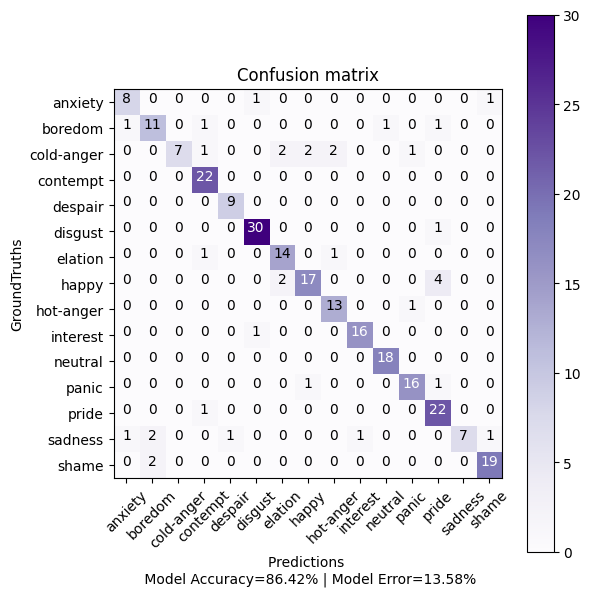

Speaker group in test set is: ['cl']
12/12 [==============================] - 0s 11ms/step
Convolutional Neural Network Accuracy:  0.842391304347826
              precision    recall  f1-score   support

     anxiety       0.87      0.95      0.91        21
     boredom       0.76      0.97      0.85        29
  cold-anger       1.00      0.81      0.90        27
    contempt       0.79      0.88      0.83        25
     despair       1.00      0.97      0.98        29
     disgust       0.73      1.00      0.85        22
     elation       0.95      0.78      0.86        27
       happy       0.64      0.86      0.73        21
   hot-anger       0.85      0.85      0.85        26
    interest       0.95      0.77      0.85        26
     neutral       0.89      1.00      0.94        17
       panic       0.92      0.57      0.71        21
       pride       0.88      0.96      0.92        24
     sadness       0.77      0.89      0.83        27
       shame       0.79      0.42      0

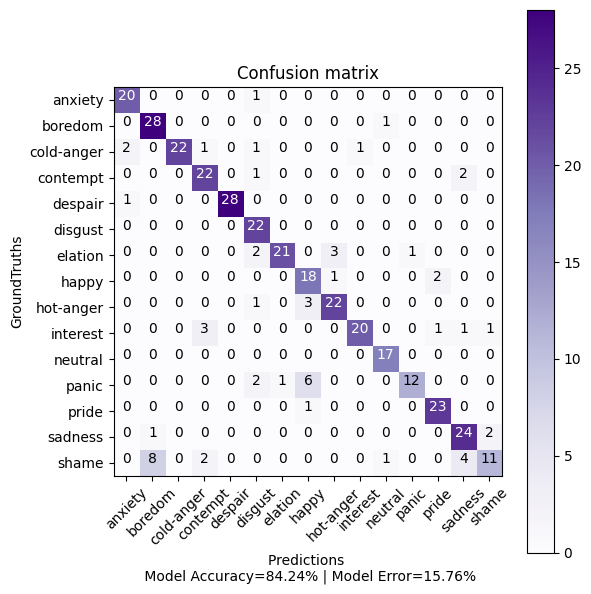

Speaker group in test set is: ['gg']
14/14 [==============================] - 0s 12ms/step
Convolutional Neural Network Accuracy:  0.9547619047619048
              precision    recall  f1-score   support

     anxiety       1.00      1.00      1.00        30
     boredom       0.88      0.97      0.92        30
  cold-anger       0.96      0.96      0.96        27
    contempt       0.93      0.96      0.94        26
     despair       0.96      0.89      0.93        28
     disgust       0.98      1.00      0.99        51
     elation       0.93      1.00      0.97        28
       happy       1.00      0.80      0.89        30
   hot-anger       1.00      0.91      0.95        22
    interest       1.00      1.00      1.00        30
     neutral       1.00      0.89      0.94         9
       panic       0.90      1.00      0.95        27
       pride       0.86      1.00      0.93        25
     sadness       1.00      1.00      1.00        33
       shame       0.95      0.83      

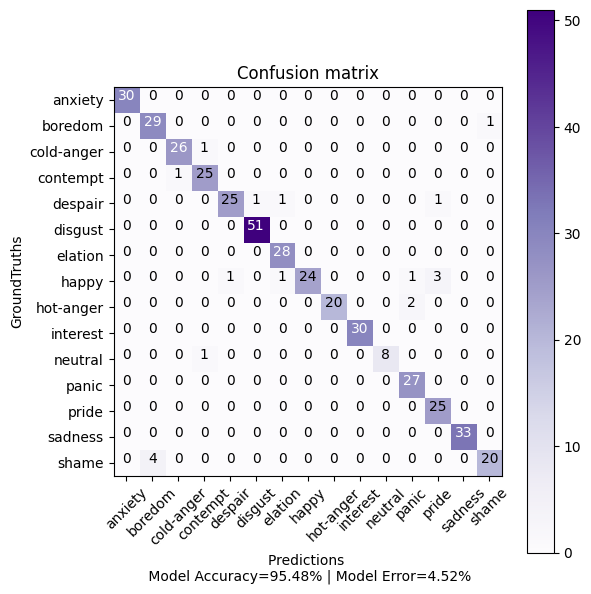

Speaker group in test set is: ['jg']
9/9 [==============================] - 0s 10ms/step
Convolutional Neural Network Accuracy:  0.7252747252747253
              precision    recall  f1-score   support

     anxiety       0.92      0.63      0.75        19
     boredom       0.71      0.71      0.71        14
  cold-anger       0.61      0.86      0.72        22
    contempt       0.64      0.70      0.67        23
     despair       0.72      0.86      0.78        21
     disgust       0.70      0.91      0.79        23
     elation       0.93      0.65      0.76        20
       happy       0.72      0.65      0.68        20
   hot-anger       0.87      0.72      0.79        18
    interest       0.88      0.79      0.83        19
     neutral       1.00      1.00      1.00         8
       panic       1.00      0.86      0.92        14
       pride       0.35      0.39      0.37        18
     sadness       0.76      0.68      0.72        19
       shame       0.57      0.53      0.

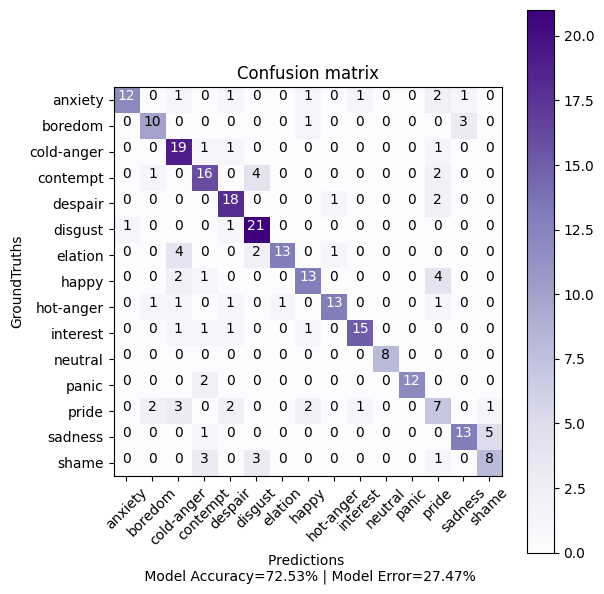

Speaker group in test set is: ['mf']
10/10 [==============================] - 0s 12ms/step
Convolutional Neural Network Accuracy:  0.7892976588628763
              precision    recall  f1-score   support

     anxiety       0.90      0.82      0.86        22
     boredom       0.88      0.85      0.87        27
  cold-anger       0.76      0.65      0.70        20
    contempt       0.83      0.89      0.86        44
     despair       0.79      0.69      0.73        16
     disgust       0.25      1.00      0.40         1
     elation       0.75      0.69      0.72        26
       happy       0.76      0.57      0.65        23
   hot-anger       0.80      0.95      0.87        21
    interest       0.73      1.00      0.84        19
     neutral       0.91      1.00      0.95        10
       panic       0.83      0.83      0.83        12
       pride       0.56      0.56      0.56        18
     sadness       0.94      0.80      0.86        20
       shame       0.71      0.75      

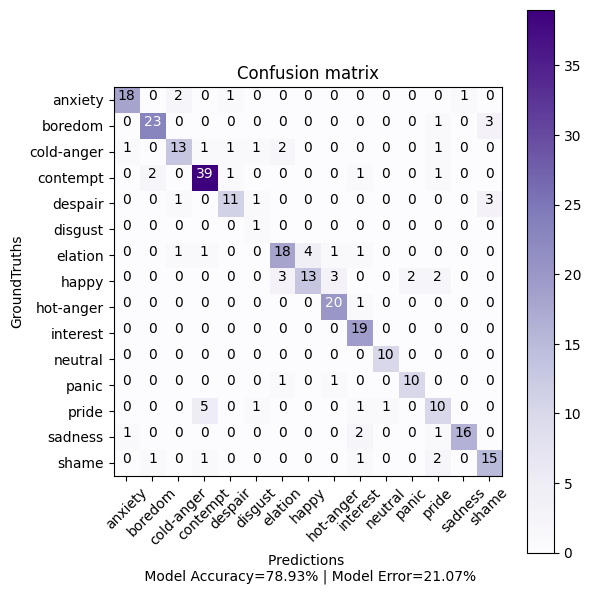

Speaker group in test set is: ['mk']
13/13 [==============================] - 0s 20ms/step
Convolutional Neural Network Accuracy:  0.7934508816120907
              precision    recall  f1-score   support

     anxiety       0.85      0.59      0.69        29
     boredom       0.69      0.90      0.78        20
  cold-anger       0.94      0.70      0.80        23
    contempt       0.58      0.67      0.62        21
     despair       0.81      0.87      0.84        53
     disgust       0.90      0.90      0.90        21
     elation       0.88      0.96      0.92        23
       happy       0.76      0.69      0.72        42
   hot-anger       0.83      0.86      0.84        22
    interest       0.81      0.80      0.80        44
     neutral       0.88      0.88      0.88         8
       panic       1.00      0.90      0.95        21
       pride       0.63      0.74      0.68        23
     sadness       1.00      0.73      0.84        22
       shame       0.64      0.84      

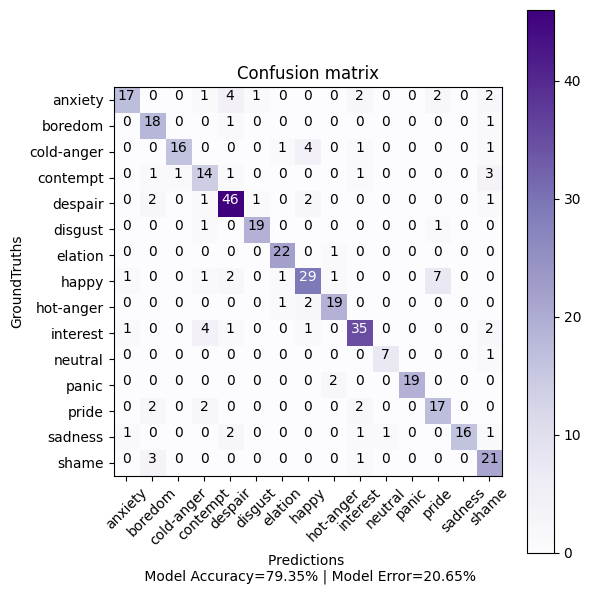

Speaker group in test set is: ['mm']
10/10 [==============================] - 0s 13ms/step
Convolutional Neural Network Accuracy:  0.8443708609271523
              precision    recall  f1-score   support

     anxiety       0.88      0.97      0.93        39
     boredom       1.00      0.47      0.64        19
  cold-anger       0.94      0.75      0.83        20
    contempt       0.90      0.95      0.92        19
     despair       0.74      0.78      0.76        18
     disgust       0.82      1.00      0.90        23
     elation       0.78      0.95      0.86        19
       happy       1.00      0.44      0.62        18
   hot-anger       1.00      1.00      1.00        16
    interest       0.64      0.86      0.73        21
     neutral       1.00      1.00      1.00         9
       panic       0.96      0.96      0.96        28
       pride       0.94      0.79      0.86        19
     sadness       0.75      0.88      0.81        17
       shame       0.63      0.71      

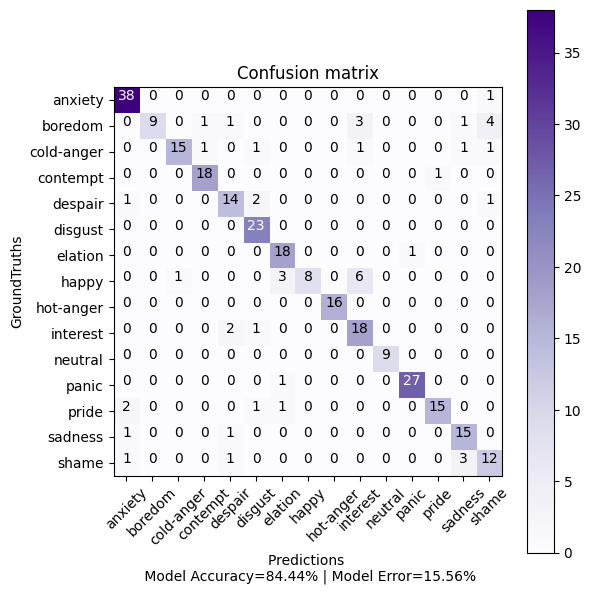

Aggregated average accuracy = 83.65
Aggregated average F1-score = 83.05


In [44]:
agg_acc = []
agg_f1 = []
for i in range(20):
        for fold, (train_idx, test_idx) in enumerate(logo.split(X, Y, speakers)):                
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = Y[train_idx], Y[test_idx]

                model = classification_model.fit(X_train, y_train, batch_size=32, epochs=20, callbacks=es,
                                                verbose=0, validation_data=(X_test, y_test), shuffle=True)
                
                if i==19:
                        print(f"Speaker group in test set is: {df.iloc[test_idx]['speaker'].unique()}")
                        y_pred = classification_model.predict(X_test)

                        y_test = np.argmax(y_test, axis=1)
                        y_pred = np.argmax(y_pred, axis=1)

                        acc = accuracy_score(y_test, y_pred)
                        f1 = f1_score(y_test, y_pred, average='macro')
                        agg_acc.append(acc * len(y_test))
                        agg_f1.append(f1 * len(y_test))
                        print("Convolutional Neural Network Accuracy: ", acc)
                        print(classification_report(y_test, y_pred, target_names=class_names))
                        cm = confusion_matrix(y_test, y_pred)
                        cr = ClassificationReport()
                        cr.plot_confusion_matrix(cm=cm, normalize = False, target_names = class_names)
agg_avg_acc = sum(agg_acc) / len(Y)
agg_avg_f1 = sum(agg_f1) / len(Y)
print(f"Aggregated average accuracy = {round(agg_avg_acc*100,2)}")
print(f"Aggregated average F1-score = {round(agg_avg_f1*100,2)}")